## Прогнозирование температуры стали во время плавления

**Задача:**
<br>
Построить модель, которая предскажет температуру стали во время плавления на металлургческом комбинате.

**Дано:**
Дданные об электродах, данные о подаче сыпучих материалов (объём и время подачи), данные о продувке сплава газом, результаты измерения температуры, данные о проволочных материалах (объём и время подачи).

## 1. Анализ данных

In [1]:
#Импортируем библиотеки и модули
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Загрузим данные
#Загрузим данные об электродах
data_arc = pd.read_csv('datasets/data_arc_new.csv')

#Загрузим данные о подаче сыпучих материалов по объёму
data_bulk = pd.read_csv('datasets/data_bulk_new.csv')

#Загрузим данные о подаче сыпучих материалов по времени
data_bulk_time = pd.read_csv('datasets/data_bulk_time_new.csv')

#Загрузим данные о продувке сплава газом
data_gas = pd.read_csv('datasets/data_gas_new.csv')

#Загрузим результаты измерения температуры
data_temp = pd.read_csv('datasets/data_temp_new.csv')

#Загрузим данные о проволочных материалах по объёму
data_wire = pd.read_csv('datasets/data_wire_new.csv')

#Загрузим данные о проволочных материалах по времени
data_wire_time = pd.read_csv('datasets/data_wire_time_new.csv')

### Данные об электродах

In [3]:
#Выведем первые 10 строк
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [4]:
#Выведем последние 10 строк
data_arc.tail(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14866,3240,2019-09-06 15:25:31,2019-09-06 15:27:32,0.669469,0.497374
14867,3240,2019-09-06 15:31:02,2019-09-06 15:33:35,0.566284,0.380893
14868,3240,2019-09-06 15:58:45,2019-09-06 16:01:15,0.382519,0.232164
14869,3240,2019-09-06 16:02:41,2019-09-06 16:07:15,0.496953,0.416185
14870,3240,2019-09-06 16:21:54,2019-09-06 16:24:15,1.202454,0.846936
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


Проверим столбец "key" на пропущенные номера партий

In [5]:
#Узнаем, есть ли пропуски в номерах партий
arc_absent_keys=set(range(1, data_arc['key'].max()+1))-set(data_arc['key'])
print(arc_absent_keys)
print('В таблице data_arc партий отсутствует:', len(arc_absent_keys))

{3200, 382, 3207, 2446, 529, 1300, 279, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 195, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766}
В таблице data_arc партий отсутствует: 27


In [6]:
#Найдём, сколько раз происходит нагрев в каждой партии, или по другому: кол-во итераций в каждой партии
data_arc.groupby('key')['Начало нагрева дугой'].count()

key
1       5
2       4
3       5
4       4
5       4
       ..
3237    5
3238    3
3239    8
3240    5
3241    5
Name: Начало нагрева дугой, Length: 3214, dtype: int64

In [7]:
#Найдём числовое описание кол-ва итераций в каждой пратии
data_arc.groupby('key')['Начало нагрева дугой'].count().describe()

count    3214.000000
mean        4.628500
std         1.608647
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Начало нагрева дугой, dtype: float64

**Вывод**:
Среднее кол-во итераций в партии - 4, минимальное - 1, максимальное - 16

In [8]:
#Посмотрим кол-во партий с разными кол-вом итераций и найдём их долю
iterations = pd.merge(data_arc.groupby('key')['Начало нагрева дугой'].count().value_counts().sort_index(), 
         data_arc.groupby('key')['Начало нагрева дугой'].count().value_counts().sort_index()/
                      data_arc.groupby('key')['Начало нагрева дугой'].count().value_counts().sort_index().sum()*100, 
         right_index = True, left_index = True)
iterations.reset_index(inplace=True)
iterations.columns = ['Кол-во итераций', 'Кол-во партий', 'Доля, %']

In [9]:
iterations.sort_values(by='Доля, %', ascending=False)

,Кол-во итераций,Кол-во партий,"Доля, %"
3,4,892,27.753578
4,5,759,23.615432
2,3,520,16.179216
5,6,490,15.245800
6,7,205,6.378345
1,2,174,5.413815
7,8,84,2.613566
0,1,39,1.213441
8,9,28,0.871189
9,10,9,0.280025


**Вывод**:
Большинство партий включает в себя 4 итерации, далее идёт партии с 5-ю итерациями, далее с 3-я и 6-ю итерациями.

In [10]:
#Выводим информацию о данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков в данных не обнаружено

In [11]:
#Числовое описание данных
data_arc.drop(['key'], axis=1).describe()

,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.662752,0.438986
std,0.258885,5.873485
min,0.223120,-715.479924
25%,0.467115,0.337175
50%,0.599587,0.441639
75%,0.830070,0.608201
max,1.463773,1.270284


Значение столбца 'Реактивная мощность' равное -715.479924 похоже на аномалию. Проверим, есть ли ещё отрицательные значения в столбце

In [12]:
data_arc['Реактивная мощность'].sort_values()

9780    -715.479924
709        0.153777
3290       0.153921
11794      0.155221
6130       0.156525
            ...    
8963       1.214912
14115      1.222632
8116       1.223063
3452       1.258628
2591       1.270284
Name: Реактивная мощность, Length: 14876, dtype: float64

Других отрицательных значений не обнаружено, модуль числа также сильно выделяется, значит, ошибка в знаке исключена.  Вывод - значение столбца 'Реактивная мощность' равное -715.479924 - аномалия

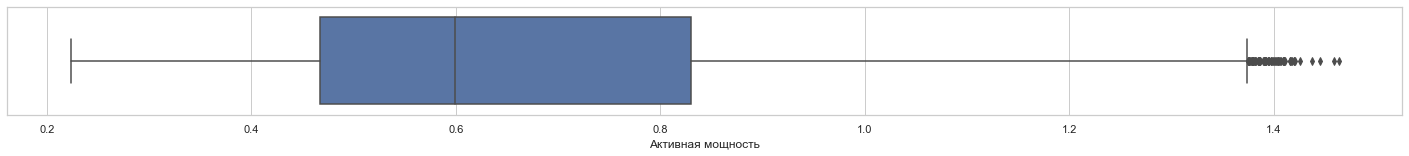

Максимум: 1.374503125


In [13]:
#Построим ящик с усами для столбца "Активная мощность"
plt.figure(figsize =(25, 2))
sns.set(style="whitegrid")
sns.boxplot(data_arc['Активная мощность']);
plt.show()
print('Максимум:', data_arc['Активная мощность'].describe()['75%'] + 
     (data_arc['Активная мощность'].describe()['75%'] - data_arc['Активная мощность'].describe()['25%'])*1.5)

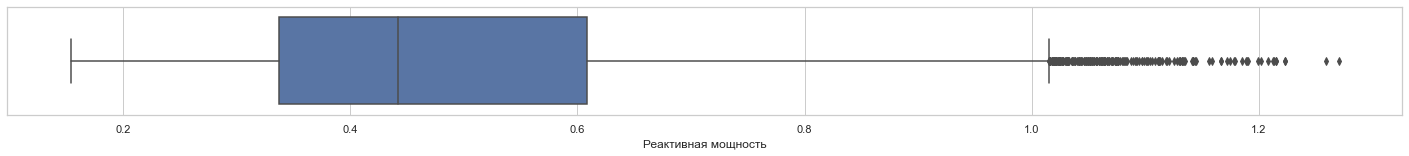

Максимум: 1.0147732499999997


In [14]:
#Построим ящик с усами для столбца "Реактивная мощность", исключив найденную аномалию
plt.figure(figsize =(25, 2))
sns.set(style="whitegrid")
sns.boxplot(data_arc['Реактивная мощность'].drop(index=9780));
plt.show()
print('Максимум:', data_arc['Реактивная мощность'].drop(index=9780).describe()['75%'] + 
     (data_arc['Реактивная мощность'].drop(index=9780).describe()['75%'] - data_arc['Реактивная мощность'].drop(index=9780).describe()['25%'])*1.5)

In [15]:
#Числовое описание данных без аномалии
data_arc.drop(['key'], axis=1).drop(index=9780).describe()

,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000
mean,0.662749,0.487115
std,0.258894,0.197612
min,0.223120,0.153777
25%,0.467115,0.337190
50%,0.599578,0.441665
75%,0.830135,0.608223
max,1.463773,1.270284


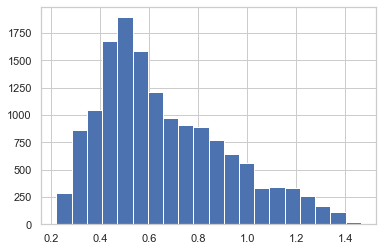

In [16]:
#Построим распределение для столбца "Активная мощность" без аномалии
data_arc['Активная мощность'].drop(index=9780).hist(bins=20);

Данные распределены нормально, но распределение имеет перекос вправо, т.к. пик распределения находится в левой стороне гистограммы, и среднее значение - 0,66 больше медианы - 0,59

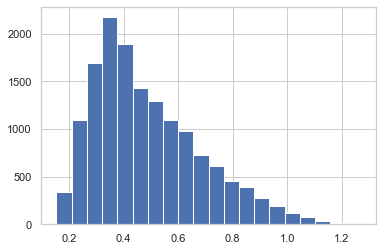

In [17]:
#Построим распределение для столбца "реактивная мощность" без аномалии
data_arc['Реактивная мощность'].drop(index=9780).hist(bins=20);

Данные распределены нормально, но распределение имеет перекос вправо, т.к. пик распределения находится в левой стороне гистограммы, и среднее значение - 0,48 больше медианы - 0,44

### Данные о подаче сыпучих материалов (объём)

In [18]:
#Выведем первые 10 строк
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [19]:
#Выведем случайные 10 строк
data_bulk.sample(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1800,1862,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0,NaN
1714,1774,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,2081,NaN,NaN,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.0,NaN,119.0,NaN
1897,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,205.0,NaN,182.0,107.0
2391,2482,NaN,NaN,NaN,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,413.0,NaN,246.0,103.0
1788,1850,NaN,NaN,NaN,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,101.0,205.0
514,543,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173.0,NaN,136.0,201.0
2738,2841,NaN,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,1148,NaN,NaN,111.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434.0,NaN,207.0,204.0
1652,1712,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.0,NaN


In [20]:
#Выведем последние 10 строк
data_bulk.tail(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,92.0,204.0
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,114.0,204.0
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0,204.0
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,118.0,206.0
3123,3236,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN,132.0,208.0
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


В начале таблицы значение столбца "key" больше индекса на 1. По выводам случайных и последних строк заметно, что значение столбца "key" больше индекса более чем на 1 и разница увеличивается к концу таблицы. Из чего можно сделать вывод, что отсутствуют данные по некоторым партиям.

In [21]:
#Найдём пропущенные партии
bulk_absent_keys=set(range(1, data_bulk['key'].max()+1))-set(data_bulk['key'])
print(bulk_absent_keys)
print('В таблице data_bulk отсутствует партий:', len(bulk_absent_keys))

{2056, 529, 540, 1566, 2595, 1062, 2599, 2600, 41, 42, 2608, 51, 52, 53, 54, 55, 56, 2103, 2625, 2628, 72, 80, 81, 1105, 1623, 607, 1133, 110, 3182, 1656, 2683, 3200, 3207, 3216, 2195, 2196, 661, 2197, 151, 2198, 2216, 2217, 683, 2738, 2739, 2231, 188, 195, 1221, 710, 225, 2278, 1268, 1783, 766, 2816, 2821, 2310, 269, 1300, 1818, 302, 2863, 2356, 1334, 830, 2884, 2373, 330, 331, 332, 2891, 2390, 343, 350, 355, 2408, 874, 1911, 1402, 382, 2434, 2446, 2460, 1437, 931, 2468, 933, 934, 1959, 2469, 2471, 1974, 1979, 2491, 960, 961, 964, 966, 3018, 3026, 983, 984, 2009, 2010, 3047, 1517, 1518, 2031, 506, 2043, 1535}
В таблице data_bulk отсутствует партий: 112


In [22]:
#Выведем информацию о данных
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Присутствуют пропуски. Думаю, это связно с тем, что какой-то материал добавляли, а какой-то нет (если Bulk 1 - Bulk 15 это разные материалы)

In [23]:
#Выведем числовое описание данных
data_bulk.drop(['key'], axis=1).describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


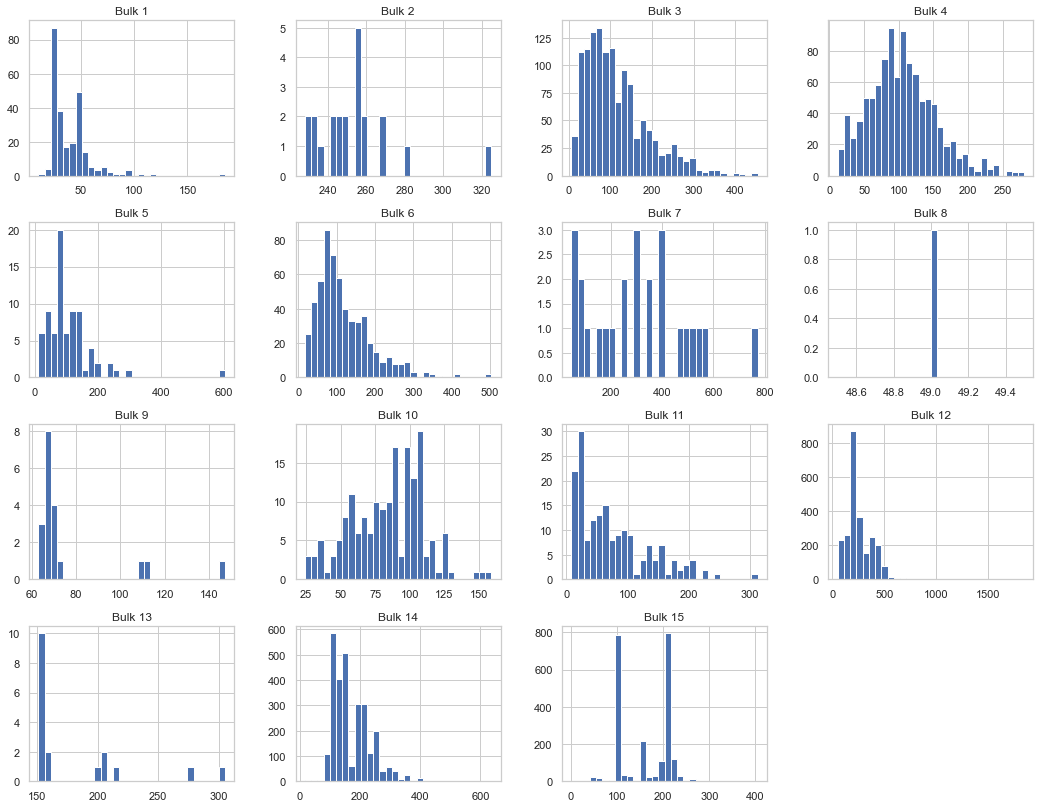

In [24]:
#Построим гистограммы распределения
data_bulk.drop(['key'], axis=1).hist(bins=30, figsize =(18, 14));

Распределения материалов 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15' имеют вид нормального распределения.

### Данные о подаче сыпучих материалов (время)

In [25]:
#Выведем первые 10 строк
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [26]:
#Выведем информацию о данных
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


По осмотру информации о данных можно сделать вывод, что ситуация аналогична данным о подаче сыпучих материалов по объёму.

### Данные о продувке сплава газом

In [27]:
#Выведем 10 первых строк
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [28]:
#Выведем 10 случайных строк
data_gas.sample(10)

,key,Газ 1
183,184,7.105241
595,598,16.999932
575,578,8.748974
606,609,12.257201
3085,3088,3.583961
1250,1253,10.265569
27,28,11.997002
2110,2113,10.457584
1857,1860,10.239209
2920,2923,8.237490


In [29]:
#Выведем 10 последних строк
data_gas.tail(10)

,key,Газ 1
3229,3232,8.630453
3230,3233,7.366606
3231,3234,9.110702
3232,3235,5.710729
3233,3236,6.958647
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [30]:
#Выведем информацию о датасете
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Проверим, всегда ли газ подаётся один раз за партию - сравним длину датасета с числом уник. значений колонки "key"

In [31]:
data_gas.shape[0] == len(data_gas['key'].unique())

True

В начале таблицы значение столбца "key" больше индекса на 1. По выводам случайных и последних строк заметно, что значение столбца "key" больше индекса более чем на 1. Из чего можно сделать вывод, что отсутствуют данные по некоторым партиям.

In [32]:
#Найдём отсутствующие номера партий
gas_absent_keys=set(range(1, data_gas['key'].max()+1))-set(data_gas['key'])
print(gas_absent_keys)
print('В таблице data_gas отсутствует партий:', len(gas_absent_keys))

{193, 259}
В таблице data_gas отсутствует партий: 2


In [33]:
#Выведем числовое описание данных
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

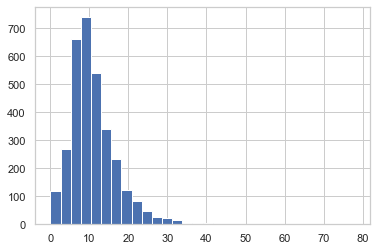

In [34]:
#Построим гистограмму распределения
data_gas['Газ 1'].hist(bins=30);

Данные распределены нормально, но распределение имеет перекос вправо, т.к. пик распределения находится в левой стороне гистограммы, и среднее значение - 11 больше медианы - 9,8

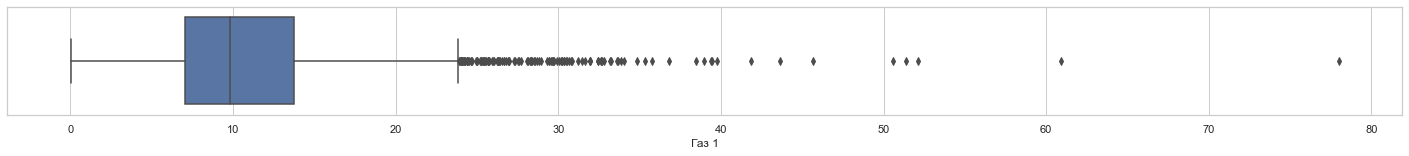

Максимум: 23.860155585675002


In [35]:
#Построим ящик с усами
plt.figure(figsize =(25, 2))
sns.set(style="whitegrid")
sns.boxplot(data_gas['Газ 1']);
plt.show()
print('Максимум:', data_gas['Газ 1'].describe()['75%'] + 
     (data_gas['Газ 1'].describe()['75%'] - data_gas['Газ 1'].describe()['25%'])*1.5)

### Результаты измерения температуры

In [36]:
#Выведем 10 первых строк
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [37]:
#Вывеедм последние 10 строк
data_temp.tail(10)

,key,Время замера,Температура
18082,3240,2019-09-06 15:58:35,NaN
18083,3240,2019-09-06 16:02:31,NaN
18084,3240,2019-09-06 16:21:44,NaN
18085,3240,2019-09-06 16:35:26,NaN
18086,3241,2019-09-06 16:48:55,1586.0
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


In [38]:
#Выведем информацию о данных
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [39]:
#Посмотрим, с какой партии начались пропуски
data_temp[data_temp['Температура'].isna()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [40]:
#Выведем первые несколько партий с пропусками
data_temp[data_temp['key'] >= 2500].head(30)

,key,Время замера,Температура
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13931,2501,2019-08-10 14:41:14,1587.0
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN


In [41]:
#Узнаем, есть ли пропуски в номерах партий
temp_absent_keys=set(range(1, data_temp['key'].max()+1))-set(data_temp['key'])
print(temp_absent_keys)
print('В таблице data_temp отсутствует партий:', len(temp_absent_keys))

{3200, 382, 3207, 2446, 529, 1300, 540, 1437, 2469, 41, 42, 683, 2356, 2103, 2491, 2373, 710, 607, 355, 2278, 1133, 2031, 506, 2683, 766}
В таблице data_temp отсутствует партий: 25


In [42]:
#Выведем числовое описание данных
data_temp.drop(['key'], axis=1).describe()

,Температура
count,14665.000000
mean,1590.722741
std,20.394381
min,1191.000000
25%,1580.000000
50%,1590.000000
75%,1599.000000
max,1705.000000


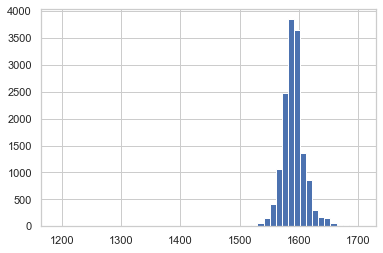

In [43]:
#Построим распределение
data_temp['Температура'].hist(bins=50);

Данные распределены нормально.

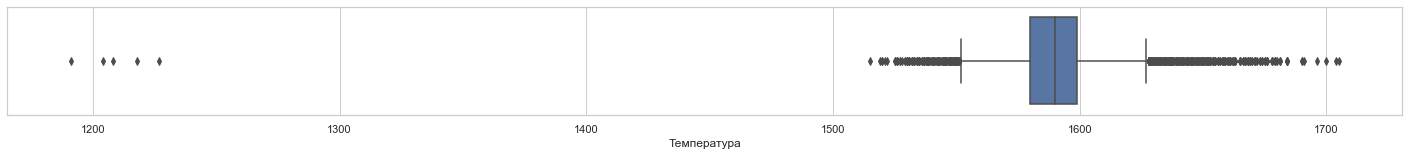

In [44]:
#Построим ящик с усами
plt.figure(figsize =(25, 2))
sns.set(style="whitegrid")
sns.boxplot(data_temp['Температура']);

### Данные о проволочных материалах (объём)

In [45]:
#Выведем первые 10 строк
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#Выведем случайные 10 строк
data_wire.sample(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1331,1402,140.072403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,621,103.942802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2574,2708,102.123840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1220,1288,189.212402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1541,1620,115.128006,65.115440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785,838,130.806000,131.376957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2081,2179,183.106567,38.092079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2221,2332,139.208160,45.149521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2219,2330,186.295197,23.494640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057,1123,60.044403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#Выведем последние 10 строк
data_wire.tail(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,15.069600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,107.147033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,110.160957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,125.099525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,101.162880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#Узнаем, есть ли пропуски в номерах партий
wire_absent_keys=set(range(1, data_wire['key'].max()+1))-set(data_wire['key'])
print(wire_absent_keys)
print('В таблице data_wire отсутствует партий:', len(wire_absent_keys))

{529, 540, 1564, 1565, 1566, 41, 42, 51, 52, 53, 54, 55, 56, 2103, 2624, 2625, 2626, 2627, 2628, 2629, 1102, 1103, 1104, 1105, 81, 82, 83, 84, 85, 1106, 88, 1107, 607, 109, 1133, 1646, 2683, 3200, 3207, 2195, 2196, 2197, 2198, 1184, 2214, 2215, 2216, 2217, 2218, 683, 2219, 2236, 2238, 195, 197, 710, 711, 712, 713, 714, 715, 1743, 1744, 209, 210, 211, 212, 1745, 1746, 1747, 1748, 1758, 2788, 2789, 2278, 2790, 744, 2791, 2792, 748, 754, 755, 766, 2814, 2815, 269, 1300, 1817, 1818, 796, 797, 798, 799, 800, 2846, 2847, 2848, 2849, 2850, 1836, 2863, 2356, 2871, 2360, 2872, 2873, 2874, 2875, 2876, 2367, 2368, 2369, 2370, 2373, 841, 330, 331, 332, 2388, 2389, 2390, 2391, 2392, 2393, 355, 1379, 1380, 375, 376, 377, 378, 382, 2446, 1946, 1437, 929, 930, 931, 932, 933, 934, 2469, 1977, 1978, 1979, 2491, 2010, 3035, 3036, 3037, 3038, 3039, 3040, 2031, 1525, 1526, 1527, 1528, 506, 2043}
В таблице data_wire отсутствует партий: 160


In [49]:
#Выведем информацию о данных
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [50]:
#Выведем числовое описание данных
data_wire.drop(['key'], axis=1).describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


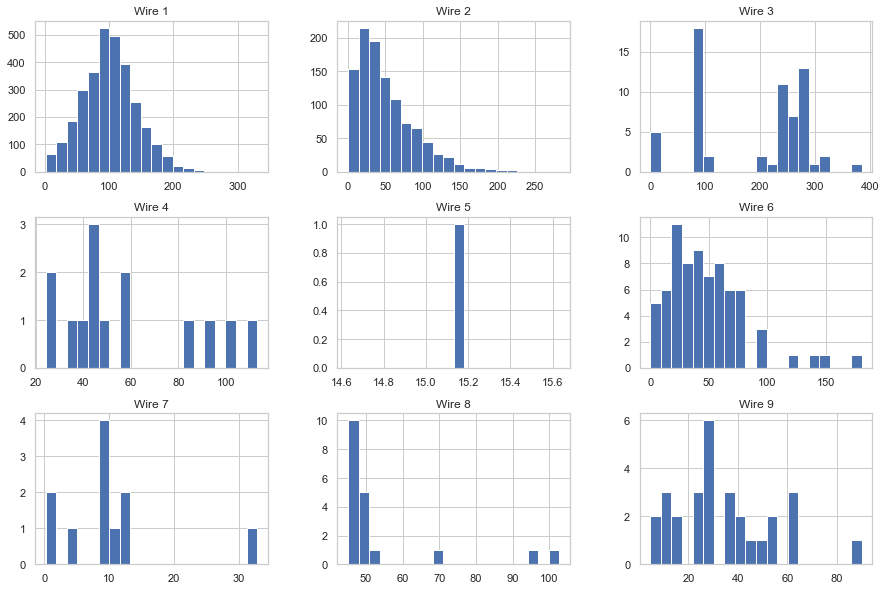

In [51]:
#Построим гистограммы распределения
data_wire.drop(['key'], axis=1).hist(bins=20, figsize =(15, 10));

Распределения материалов 'Wire 1' и 'Wire 2' имеют вид нормального распределения.

### Данные о проволочных материалах (время)

In [52]:
#Выведем первые 10 строк
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#Выведем случайные 10 строк
data_wire_time.sample(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
145,161,2019-05-09 19:00:31,2019-05-09 18:54:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286,1355,2019-06-23 16:10:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,1263,2019-06-20 02:51:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2372,2499,2019-08-10 13:45:26,2019-08-10 13:38:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1391,1463,2019-06-27 14:08:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2423,2550,2019-08-12 08:29:22,2019-08-12 08:23:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2562,2696,2019-08-17 17:56:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1892,1986,2019-07-22 20:44:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1761,1851,2019-07-11 02:58:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,410,2019-05-19 04:44:31,2019-05-19 04:39:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#Выведем последние 10 строк
data_wire_time.tail(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,2019-09-06 08:43:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,2019-09-06 09:18:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,2019-09-06 09:43:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,2019-09-06 10:21:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,2019-09-06 10:57:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
#Выведем информацию о данных
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


По информации о данных видно, что ситуация аналогична данным об объёмах проволочных материалов

### Найдём последовательность процессов в партии

**Данные об электродах**

In [56]:
data_arc_start = data_arc[['key', 'Начало нагрева дугой']]
data_arc_start.columns = ['key', 'time']
data_arc_start['operation'] = 'Начало нагрева дугой'

In [57]:
data_arc_start

,key,time,operation
0,1,2019-05-03 11:02:14,Начало нагрева дугой
1,1,2019-05-03 11:07:28,Начало нагрева дугой
2,1,2019-05-03 11:11:44,Начало нагрева дугой
3,1,2019-05-03 11:18:14,Начало нагрева дугой
4,1,2019-05-03 11:26:09,Начало нагрева дугой
...,...,...,...
14871,3241,2019-09-06 16:49:05,Начало нагрева дугой
14872,3241,2019-09-06 16:55:11,Начало нагрева дугой
14873,3241,2019-09-06 17:06:48,Начало нагрева дугой
14874,3241,2019-09-06 17:21:58,Начало нагрева дугой


In [58]:
data_arc_finish = data_arc[['key', 'Конец нагрева дугой']]
data_arc_finish.columns = ['key', 'time']
data_arc_finish['operation'] = 'Конец нагрева дугой'

In [59]:
data_arc_finish

,key,time,operation
0,1,2019-05-03 11:06:02,Конец нагрева дугой
1,1,2019-05-03 11:10:33,Конец нагрева дугой
2,1,2019-05-03 11:14:36,Конец нагрева дугой
3,1,2019-05-03 11:24:19,Конец нагрева дугой
4,1,2019-05-03 11:28:37,Конец нагрева дугой
...,...,...,...
14871,3241,2019-09-06 16:51:42,Конец нагрева дугой
14872,3241,2019-09-06 16:58:11,Конец нагрева дугой
14873,3241,2019-09-06 17:09:52,Конец нагрева дугой
14874,3241,2019-09-06 17:22:55,Конец нагрева дугой


**Данные о сыпучих материалах**

In [60]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34


In [61]:
#data_bulk_time.iloc[0]

In [62]:
#Создадим таблицу для первой партии

bulk_operations = data_bulk_time.iloc[0].dropna().reset_index()
bulk_operations.columns = ['operation', 'time']
bulk_operations['key'] = bulk_operations.iloc[0]['time']
bulk_operations.drop(0, axis=0, inplace=True)
bulk_operations = bulk_operations[['key', 'time', 'operation']]

#Добавим следующие партии
for i in range (1, data_bulk_time.shape[0]):
    table = data_bulk_time.iloc[i].dropna().reset_index()
    table.columns = ['operation', 'time']
    table['key'] = table.iloc[0]['time']
    table.drop(0, axis=0, inplace=True)
    table = table[['key', 'time', 'operation']]
    bulk_operations = pd.concat([bulk_operations, table])

In [63]:
bulk_operations

,key,time,operation
1,1,2019-05-03 11:28:48,Bulk 4
2,1,2019-05-03 11:24:31,Bulk 12
3,1,2019-05-03 11:14:50,Bulk 14
4,1,2019-05-03 11:10:43,Bulk 15
1,2,2019-05-03 11:36:50,Bulk 4
...,...,...,...
1,3240,2019-09-06 16:24:28,Bulk 6
2,3240,2019-09-06 16:07:29,Bulk 14
3,3240,2019-09-06 16:01:34,Bulk 15
1,3241,2019-09-06 17:26:33,Bulk 14


**Данные о проволочных материалах**

In [64]:
#data_wire_time.head(20)

In [65]:
#Создадим таблицу для первой партии

wire_operations = data_wire_time.iloc[0].dropna().reset_index()
wire_operations.columns = ['operation', 'time']
wire_operations['key'] = wire_operations.iloc[0]['time']
wire_operations.drop(0, axis=0, inplace=True)
wire_operations = wire_operations[['key', 'time', 'operation']]
wire_operations

#Добавим следующие партии
for i in range (1, data_wire_time.shape[0]):
    table = data_wire_time.iloc[i].dropna().reset_index()
    table.columns = ['operation', 'time']
    table['key'] = table.iloc[0]['time']
    table.drop(0, axis=0, inplace=True)
    table = table[['key', 'time', 'operation']]
    wire_operations = pd.concat([wire_operations, table])

In [66]:
#wire_operations.head(30)

**Данные о температуре**

In [67]:
#Выведем 10 первых строк
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [68]:
temp_operations = data_temp.copy()
temp_operations['operation'] = 'Замер температуры'
temp_operations.drop('Температура', axis=1, inplace=True)
temp_operations.columns=['key', 'time', 'operation']
temp_operations

,key,time,operation
0,1,2019-05-03 11:02:04,Замер температуры
1,1,2019-05-03 11:07:18,Замер температуры
2,1,2019-05-03 11:11:34,Замер температуры
3,1,2019-05-03 11:18:04,Замер температуры
4,1,2019-05-03 11:25:59,Замер температуры
...,...,...,...
18087,3241,2019-09-06 16:55:01,Замер температуры
18088,3241,2019-09-06 17:06:38,Замер температуры
18089,3241,2019-09-06 17:21:48,Замер температуры
18090,3241,2019-09-06 17:24:44,Замер температуры


**Итоговая таблица порядка операций**

In [69]:
# Соединим полученные выше таблицы
order_table = pd.concat([data_arc_start, data_arc_finish, bulk_operations, wire_operations, temp_operations])

In [70]:
# Упорядочим итоговую таблицу операций по времени
order_table = order_table.sort_values('time')
order_table.reset_index(drop=True, inplace=True)
order_table

,key,time,operation
0,1,2019-05-03 11:02:04,Замер температуры
1,1,2019-05-03 11:02:14,Начало нагрева дугой
2,1,2019-05-03 11:06:02,Конец нагрева дугой
3,1,2019-05-03 11:06:19,Wire 1
4,1,2019-05-03 11:07:18,Замер температуры
...,...,...,...
63342,3241,2019-09-06 17:24:44,Замер температуры
63343,3241,2019-09-06 17:24:54,Начало нагрева дугой
63344,3241,2019-09-06 17:26:15,Конец нагрева дугой
63345,3241,2019-09-06 17:26:33,Bulk 14


In [71]:
# Выведем данные для определённых партий
order_table.loc[order_table['key'].isin([1, 2, 99])]

,key,time,operation
0,1,2019-05-03 11:02:04,Замер температуры
1,1,2019-05-03 11:02:14,Начало нагрева дугой
2,1,2019-05-03 11:06:02,Конец нагрева дугой
3,1,2019-05-03 11:06:19,Wire 1
4,1,2019-05-03 11:07:18,Замер температуры
5,1,2019-05-03 11:07:28,Начало нагрева дугой
6,1,2019-05-03 11:10:33,Конец нагрева дугой
7,1,2019-05-03 11:10:43,Bulk 15
8,1,2019-05-03 11:11:34,Замер температуры
9,1,2019-05-03 11:11:44,Начало нагрева дугой


По полученной таблице можно проследить порядок действий в партии:
1. Замер температуры
2. Начало нагрева дугой
3. Конец нагрева дугой
4. Добавление сыпучего и/или проволочного материала
5. Повторный замер температуры

Если в результате повторного замера температуры (п.5) температура и химический состав сплава не удовлетворяют нужным требованиям, то пп. 2-5 повторяются до достижения сплавом необходимых требований.

**Выводы по первичному анализу данных**

1. В данных о нагреве электродами обнаружено аномальное значение столбца "Реактивная мощность". Очевидная ошибка в данных, т.к. значение отрицательное и его модуль в разы отличается от остальных значений.
2. В данных по объёмам сыпучих и проволочных материалов присутствуют пропуски. Вероятно пропуск означает, что данный материал в партии не подавался
3. В данных о замерах температуры присутствуют значения в районе 1200, ниже температуры плавления 1400 градусов. 
4. В данных о замерах температуры начиная с партии №2500 данные есть только по первичному замеру, по промежуточным и финальному замеру данные отсутствуют.

## Часть 2. Моделирование

### 1. Предобрабокта данных и создание признаков

#### Данные об электродах

In [72]:
#Удалим партию с аномалией значения "Реактивная мощность" равным - 715
data_arc = data_arc.query('key != 2116')

In [73]:
#Выведм отписание данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14872 non-null  int64  
 1   Начало нагрева дугой  14872 non-null  object 
 2   Конец нагрева дугой   14872 non-null  object 
 3   Активная мощность     14872 non-null  float64
 4   Реактивная мощность   14872 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.1+ KB


In [74]:
#Снова выведем числовое писание данных
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.662753,0.487112
std,934.661090,0.258916,0.197623
min,1.000000,0.223120,0.153777
25%,806.000000,0.467114,0.337175
50%,1616.000000,0.599587,0.441667
75%,2429.000000,0.830314,0.608201
max,3241.000000,1.463773,1.270284


In [75]:
#Провекра на явные дубликаты
data_arc.duplicated().sum()

0

#### Данные о сыпучих материалах

In [76]:
#Заполним пропуски 0
data_bulk = data_bulk.fillna(0)

In [77]:
#Добавим столбец с суммарным объёмом всех материалов
data_bulk['Bulk total'] = data_bulk.loc[:, 'Bulk 1':'Bulk 15'].sum(axis=1)

In [78]:
#Проверим результат
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk total
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,758.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,272.0


Посмотрим, есть ли партии, в которых суммарный объём всех материалов = 0

In [79]:
#Найдём партию c минимальным суммарным объёмом материалов
data_bulk['Bulk total'].min()

19.0

Партий с суммарным общим объёмом раным 0 не обнаружено. Следовательно, пропуски в данных отсутствуют.

In [80]:
#Провекра на явные дубликаты
data_bulk.duplicated().sum()

0

#### Данные о проволочных материалах

In [81]:
#Заполним пропуски 0
data_wire = data_wire.fillna(0)

In [82]:
#Добавим столбец с суммарным объёмом всех материалов
data_wire['Wire total'] = data_wire.loc[:, 'Wire 1':'Wire 9'].sum(axis=1)

In [83]:
#Проверим результат
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire total
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.070400


Посмотрим, есть ли партии, в которых суммарный объём всех материалов = 0

In [84]:
#Найдём партию c минимальным суммарным объёмом материалов
data_wire['Wire total'].min()

1.9188

Партий с суммарным общим объёмом раным 0 не обнаружено. Следовательно, пропуски в данных отсутствуют.

In [85]:
#Провекра на явные дубликаты
data_wire.duplicated().sum()

0

#### Данные о газе

In [86]:
#Провекра на явные дубликаты
data_gas.duplicated().sum()

0

#### Результаты измерения температуры

Удалим партии с номерами более 2500 включительно, т.к. в них присутствуют данные только по первончальному замеру, а по следующим и по финальному замеру данные отсутствуют.

In [87]:
data_temp = data_temp.query('key < 2500')

Удалим партии, в которых значение температуры было ниже 1400

In [88]:
for i in data_temp.query('Температура < 1400')['key'].unique():
    data_temp = data_temp.query('key != @i')

In [89]:
#Выведем числовое описание данных для проверки
data_temp.describe()

,key,Температура
count,13905.00000,13905.000000
mean,1243.32571,1590.924847
std,719.39552,18.750314
min,1.00000,1519.000000
25%,623.00000,1580.000000
50%,1246.00000,1590.000000
75%,1870.00000,1599.000000
max,2499.00000,1705.000000


In [90]:
#Провекра на явные дубликаты
data_temp.duplicated().sum()

0

### Найдём ключи, которые есть во всех датафреймах

Найдём число ключей в каждом датафрейме и выберем среди них минимальное значение

In [91]:
n = []

n.append(data_arc.iloc[-1]['key'])
n.append(data_bulk.iloc[-1]['key'])
n.append(data_gas.iloc[-1]['key'])
n.append(data_temp.iloc[-1]['key'])
n.append(data_wire.iloc[-1]['key'])

min(n)

2499

Максимальное число партий - 2499

In [92]:
#Создадим множество
all_keys = set(range(1, 2500))

Удалим во всех таблицах партии с ключами более 2499

In [93]:
data_arc = data_arc.query('key < 2500')
data_bulk = data_bulk.query('key < 2500')
data_gas = data_gas.query('key < 2500')
data_wire = data_wire.query('key < 2500')

После удаления выбросов данные о ключах в таблицах изменились. Заново найдём отсутствующие ключи в каждой таблице

In [94]:
#Найдём пропущенные ключи в каждом датафрейме
data_arc_absent_keys = all_keys - set(data_arc['key'])
data_bulk_absent_keys = all_keys - set(data_bulk['key'])
data_gas_absent_keys = all_keys - set(data_gas['key'])
data_wire_absent_keys = all_keys - set(data_wire['key'])
data_temp_absent_keys = all_keys - set(data_temp['key'])

In [95]:
#Найдём список ключей, которые есть во всех таблицах
available_keys = all_keys - data_arc_absent_keys \
- data_bulk_absent_keys \
- data_gas_absent_keys \
- data_wire_absent_keys \
- data_temp_absent_keys

In [96]:
#available_keys

Оставим в таблицах только вышенайденные ключи

In [97]:
data_arc = data_arc[data_arc['key'].isin(available_keys)]
data_bulk = data_bulk[data_bulk['key'].isin(available_keys)]
data_gas = data_gas[data_gas['key'].isin(available_keys)]
data_wire = data_wire[data_wire['key'].isin(available_keys)]
data_temp = data_temp[data_temp['key'].isin(available_keys)]

In [98]:
#Перезапишем индексы
data_arc.reset_index(drop=True, inplace=True)
data_bulk.reset_index(drop=True, inplace=True)
data_gas.reset_index(drop=True, inplace=True)
data_wire.reset_index(drop=True, inplace=True)
data_temp.reset_index(drop=True, inplace=True)

### Добавим новые признаки

#### Данные об электродах

Преобразуем столбцы со временем в формат datetime и найдём время нагрева в секундах. Запишем его в новый столбец

In [99]:
#Преобразуем столбы в новый формат
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [100]:
#Создадим новый столбец - "Время нагрева, с."
data_arc['Время нагрева, с.'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])

In [101]:
#Заполним новый столбец "ВРемя нагрева, с." значениями в секундах
data_arc['Время нагрева, с.'] = data_arc['Время нагрева, с.'].apply(lambda x: x.total_seconds())

In [102]:
#Проверим результат
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, с."
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0


Создадим новый столбец - "Полная мощность", значения которого вычислим по формуле:

$$
S = \sqrt{P^2 + Q^2}
$$

Где:<br>
S - полная мощность<br>
P - активная мощность<br>
Q - реактивная мощность<br>

In [103]:
#Создадим новый столбец - "Полная мощность"
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5

In [104]:
#Проверим результат
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Время нагрева, с.",Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,0.440239
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,338.0,0.332731
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,126.0,0.860064
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,210.0,0.955315
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,280.0,1.373863


In [105]:
# Сгруппируем таблицу по столбцу key. Получим колонки: 
# - номер партии key 
# - кол-во итераций в партии 
# - средняя полная мощность итерации 
# - время нагрева в партии, сек.
data_arc_final = data_arc.groupby('key')[['Полная мощность', 'Время нагрева, с.']] \
.agg({'Полная мощность':['count', 'median'], 'Время нагрева, с.':'sum'}).reset_index()

#Переименуем столбцы
data_arc_final.columns = ['key', 'iterations', 'avg_power', 'time_total']

In [106]:
#Проверим результат
data_arc_final

,key,iterations,avg_power,time_total
0,1,5,0.722536,1098.0
1,2,4,0.650151,811.0
2,3,5,0.925082,655.0
3,4,4,0.954624,741.0
4,5,4,0.639021,869.0
...,...,...,...,...
2319,2495,4,1.026061,723.0
2320,2496,6,0.647846,940.0
2321,2497,3,1.531931,569.0
2322,2498,5,0.625538,750.0


#### Данные о сыпучих материалах

Удалим колонку с общим объёмом всех материалов за партию. Считаю данный признак неподходящим для модели, т.к. материалы разные

In [107]:
#Удалим колонку
data_bulk_final = data_bulk.drop('Bulk total', axis=1)

In [108]:
#Приведём названия колонок к нижнему регистру и заменим пробел на "_"
new_columns = []

for i in data_bulk_final.columns:
    new_columns.append('_'.join(i.split(' ')).lower())
    
data_bulk_final.columns = new_columns

#Проверим результат
data_bulk_final.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


#### Данные опроволочных материалах

Удалим колонку с общим объёмом всех материалов за партию. Считаю данный признак неподходящим для модели, т.к. материалы разные

In [109]:
#Удалим колонку
data_wire_final = data_wire.drop('Wire total', axis=1)

In [110]:
#Приведём названия колонок к нижнему регистру и заменим пробел на "_"
new_columns = []

for i in data_wire_final.columns:
    new_columns.append('_'.join(i.split(' ')).lower())
    
data_wire_final.columns = new_columns

#Проверим результат
data_wire_final.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Данные по газу

In [111]:
#Создадим финальную таблицу по газу
data_gas_final = data_gas.copy()

In [112]:
#Зададим новые названия колонок
data_gas_final.columns = ['key', 'gas']

In [113]:
#Проверим результат
data_gas_final.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


#### Данные по температуре

Для каждой партии создадим список со следующими значениями:
- Номер партии key
- Начальный замер в партии
- Конечный замер в партии

In [114]:
#Создадим список, в который включим списки с вышеперечисленными значениями для всех партий
temp_list = []

#Пройдём циклом по списку ключей
for i in available_keys:
    #Добавим в список temp_list список со значениями key, начального и финального замеров температуры партии
    temp_list.append([i, list(data_temp.query('key == @i')['Температура'])[0], list(data_temp.query('key == @i')['Температура'])[-1]])

In [115]:
#temp_list

In [116]:
#Создадим таблицу из списка temp_list
data_temp_final = pd.DataFrame(temp_list, columns=['key' , 'temp_start', 'temp_final'])

In [117]:
#Проверим результат
data_temp_final

,key,temp_start,temp_final
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2319,2495,1570.0,1591.0
2320,2496,1554.0,1591.0
2321,2497,1571.0,1589.0
2322,2498,1591.0,1594.0


### 2. Создание объединённой таблицы признаков

In [118]:
#Соединим таблицы
data_final = data_arc_final.merge(data_bulk_final, on='key')
data_final = data_final.merge(data_wire_final, on='key')
data_final = data_final.merge(data_gas_final, on='key')
data_final = data_final.merge(data_temp_final, on='key')

In [119]:
#Выведем финальную таблицу
pd.set_option('display.max_columns', 31)
data_final

,key,iterations,avg_power,time_total,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas,temp_start,temp_final
0,1,5,0.722536,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
1,2,4,0.650151,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0
2,3,5,0.925082,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0
3,4,4,0.954624,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0
4,5,4,0.639021,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,4,1.026061,723.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1570.0,1591.0
2320,2496,6,0.647846,940.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1554.0,1591.0
2321,2497,3,1.531931,569.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1571.0,1589.0
2322,2498,5,0.625538,750.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,1591.0,1594.0


**Описание таблицы**:
- **key** - номер партии
- **iterations** - кол-во нагревов электродами за партию
- **avg_power** - средняя полная мощность за нагрев
- **time_total** - полное время нагрева за партию, сек.
- **bulk_1 ... bulk_15** - объём сыпучего материала за партию
- **wire_1 ... wire_9** - объём прволочного материала за партию
- **gas** - данные по газ за партию
- **temp_start** - температура во время начального замера
- **temp_final** - температура во время финального замера. ***Целевой признак***

In [120]:
#Выведем информацию о данных
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2324 non-null   int64  
 1   iterations  2324 non-null   int64  
 2   avg_power   2324 non-null   float64
 3   time_total  2324 non-null   float64
 4   bulk_1      2324 non-null   float64
 5   bulk_2      2324 non-null   float64
 6   bulk_3      2324 non-null   float64
 7   bulk_4      2324 non-null   float64
 8   bulk_5      2324 non-null   float64
 9   bulk_6      2324 non-null   float64
 10  bulk_7      2324 non-null   float64
 11  bulk_8      2324 non-null   float64
 12  bulk_9      2324 non-null   float64
 13  bulk_10     2324 non-null   float64
 14  bulk_11     2324 non-null   float64
 15  bulk_12     2324 non-null   float64
 16  bulk_13     2324 non-null   float64
 17  bulk_14     2324 non-null   float64
 18  bulk_15     2324 non-null   float64
 19  wire_1      2324 non-null  

In [121]:
#Изменим типы столбцов time_total, temp_start и temp_final на int
data_final[['time_total', 'temp_start','temp_final']] = data_final[['time_total', 'temp_start','temp_final']].astype('int64')

Исследование объёдинённого датафрейма

In [122]:
#Получим числовое описание данных
data_final.drop('key', axis=1).describe()

,iterations,avg_power,time_total,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas,temp_start,temp_final
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,4.696644,0.789534,808.196644,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.021084,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,11.378854,1587.368761,1593.372633
std,1.606210,0.188725,340.813828,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,1.016431,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,6.397008,23.627590,11.207457
min,1.000000,0.288771,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000
25%,4.000000,0.647567,581.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282534,1571.000000,1587.000000
50%,5.000000,0.764380,778.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100687,1587.000000,1593.000000
75%,6.000000,0.901291,993.000000,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.218487,1603.000000,1598.000000
max,16.000000,1.581864,4189.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040,1660.000000,1653.000000


В столбце wire_5 отсутствуют среднее, минимальное и максимальное значение. Следовательно, все значения этого столбца равны 0 и являютя заменёнными пропусками. Удалим данный признак из таблицы.

In [123]:
data_final = data_final.drop(['wire_5'], axis=1)

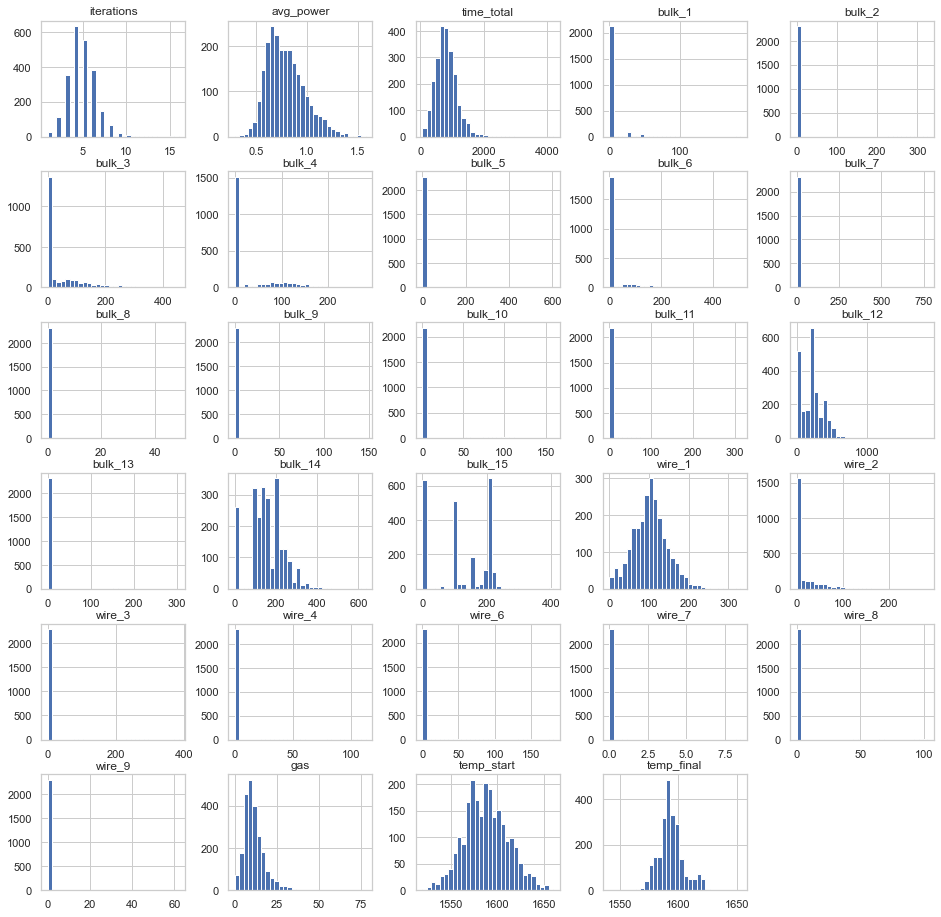

In [124]:
#Построим гистограммы распределения
data_final.drop(['key'], axis=1).hist(bins=30, figsize =(16, 16));

### 3. Проверка признаков на мультиколлениарность

In [125]:
#Выведем таблицу корреляции
pd.set_option('display.max_columns', 31)
corr_table = data_final.drop('key', axis=1).corr().round(2)
corr_table

,iterations,avg_power,time_total,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas,temp_start,temp_final
iterations,1.00,-0.01,0.80,0.10,0.09,0.11,-0.00,0.08,0.15,0.15,-0.01,0.04,0.01,0.06,0.31,0.12,0.33,0.17,0.14,0.08,0.06,0.11,0.05,0.07,0.04,-0.02,0.40,-0.18,0.18
avg_power,-0.01,1.00,0.02,0.03,-0.01,0.01,0.03,-0.01,-0.01,-0.01,-0.04,-0.02,-0.01,0.01,0.03,-0.01,0.01,0.02,0.03,-0.03,0.02,-0.01,-0.01,-0.01,-0.01,0.01,0.03,0.00,0.03
time_total,0.80,0.02,1.00,0.10,0.04,0.09,-0.03,0.01,0.16,0.08,-0.01,0.01,-0.01,0.08,0.47,0.13,0.46,0.29,0.06,0.05,0.03,0.05,0.04,0.03,0.02,-0.01,0.40,-0.38,0.28
bulk_1,0.10,0.03,0.10,1.00,0.22,-0.01,0.04,0.06,-0.00,0.24,-0.01,-0.02,-0.02,-0.04,0.33,-0.01,0.21,-0.00,0.01,-0.01,0.02,0.15,0.15,0.08,-0.02,0.01,0.23,0.08,-0.08
bulk_2,0.09,-0.01,0.04,0.22,1.00,-0.05,0.04,0.36,-0.03,0.68,-0.00,-0.01,-0.02,0.00,-0.10,-0.01,-0.14,-0.11,-0.17,-0.04,0.22,0.70,0.56,0.43,-0.01,-0.01,0.22,0.14,-0.08
bulk_3,0.11,0.01,0.09,-0.01,-0.05,1.00,-0.30,-0.01,0.07,-0.03,0.02,0.01,-0.09,-0.01,0.02,-0.01,0.01,-0.01,0.04,0.09,0.01,-0.04,0.01,-0.02,0.00,0.00,0.06,-0.11,-0.04
bulk_4,-0.00,0.03,-0.03,0.04,0.04,-0.30,1.00,0.03,-0.25,0.05,-0.01,-0.00,-0.08,-0.12,0.11,0.00,-0.09,0.10,0.30,-0.27,-0.04,0.03,-0.01,0.03,0.01,-0.06,0.02,0.17,0.19
bulk_5,0.08,-0.01,0.01,0.06,0.36,-0.01,0.03,1.00,-0.02,0.29,-0.00,-0.01,-0.03,-0.02,-0.07,-0.01,-0.07,-0.07,-0.01,-0.01,0.07,0.26,0.20,0.17,-0.01,-0.01,0.09,0.08,-0.03
bulk_6,0.15,-0.01,0.16,-0.00,-0.03,0.07,-0.25,-0.02,1.00,-0.03,-0.01,-0.03,-0.10,0.20,-0.11,0.04,0.18,-0.11,-0.24,0.21,-0.05,-0.03,-0.02,-0.01,-0.03,-0.01,0.14,-0.13,-0.18
bulk_7,0.15,-0.01,0.08,0.24,0.68,-0.03,0.05,0.29,-0.03,1.00,-0.00,-0.00,-0.02,-0.00,-0.02,-0.00,-0.08,-0.09,-0.14,-0.00,0.16,0.74,0.46,0.37,-0.00,-0.01,0.20,0.09,-0.11


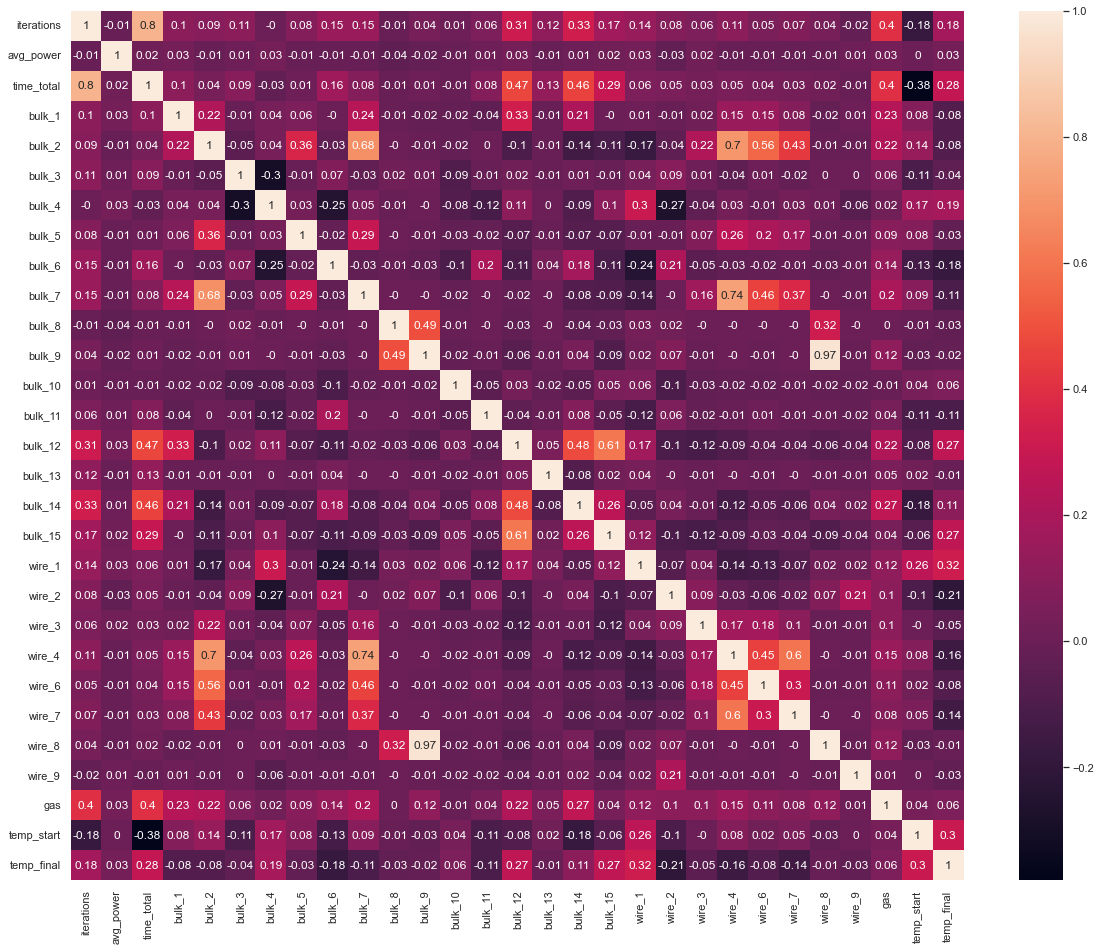

In [126]:
#Выведем тепловую карту корреляции
plt.figure(figsize = (20,16))
sns.heatmap(corr_table, annot= True);

Составим таблицу корреляции целевого признака temp_final с остальными признаками

In [127]:
temp_final_corr = []

for i in data_final.drop(['key', 'temp_final'], axis=1).columns:
    temp_final_corr.append([i, data_final['temp_final'].corr(data_final[i]).round(2)])
    
data_temp_final_corr = pd.DataFrame(temp_final_corr, columns = ['Признак', 'Корреляция с temp_final'])

data_temp_final_corr['Направление'] = \
data_temp_final_corr['Корреляция с temp_final'].apply(lambda x: 'Прямая' if x >0 else 'Обратная')
data_temp_final_corr['Корреляция с temp_final'] = abs(data_temp_final_corr['Корреляция с temp_final'])

data_temp_final_corr.sort_values('Корреляция с temp_final', ascending=False)

,Признак,Корреляция с temp_final,Направление
18,wire_1,0.32,Прямая
27,temp_start,0.30,Прямая
2,time_total,0.28,Прямая
17,bulk_15,0.27,Прямая
14,bulk_12,0.27,Прямая
19,wire_2,0.21,Обратная
6,bulk_4,0.19,Прямая
0,iterations,0.18,Прямая
8,bulk_6,0.18,Обратная
21,wire_4,0.16,Обратная


**Вывод**: обнаружено 2 пары признаков с высоким коэффициентом корреляции Пирсона:<br>
- 'iterations' и 'time_total' - к-т корреляции = 0,8
- 'bulk_9' и 'wire_8' - к-т корреляции = 0,97

Удалим из таблицы по одному признаку из этих пар, которые меньше коррелируют с целевым признаком:
- 'iterations'
- 'wire_8'

In [128]:
data_final.drop(['iterations', 'wire_8'], axis=1, inplace=True)

### 4. Разделение данных на выборки

In [129]:
#Зададим константу для random_state
RANDOM = 190623

In [130]:
#Выделим признаки и целевой признак
features = data_final.drop(['key', 'temp_final'], axis=1)
target = data_final['temp_final']

In [131]:
#Выделим обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM)

**Масштабирование признаков**

In [132]:
# Создаём скелер
scaler = StandardScaler()

# обучаем его на тренировочной выборке и сразу трансформируем её
X_train = scaler.fit_transform(X_train)

In [133]:
#смотрим на результат
X_train

array([[ 0.38668862,  0.80603041, -0.27979117, ..., -0.07085764,
         0.70711318, -0.10242807],
       [-0.12292852,  0.61697232, -0.27979117, ..., -0.07085764,
         1.01738642,  0.02440034],
       [ 1.97646898, -1.28233431, -0.27979117, ..., -0.07085764,
        -0.55589834, -0.06015193],
       ...,
       [ 0.8027444 , -0.63662822, -0.27979117, ..., -0.07085764,
         0.05791828, -0.56746559],
       [ 2.64075475,  0.67223546, -0.27979117, ..., -0.07085764,
        -0.0775144 ,  0.74309469],
       [ 0.59930975, -0.38939842, -0.27979117, ..., -0.07085764,
        -0.71358097, -0.73657014]])

In [134]:
#Трансформируем тестовую выборку
X_test = scaler.transform(X_test)

In [135]:
#Смотрим на результат
X_test

array([[-0.96238756, -0.13635144, -0.27979117, ..., -0.07085764,
         1.12651704,  0.8699231 ],
       [-0.68424492,  2.10035116, -0.27979117, ..., -0.07085764,
         1.62511264,  0.23578103],
       [-0.38985758,  0.97763698, -0.27979117, ..., -0.07085764,
        -1.46613663,  0.15122876],
       ...,
       [ 1.10901751, -0.14798578, -0.27979117, ..., -0.07085764,
        -0.12194288, -0.73657014],
       [ 1.32693844, -0.58427368, -0.27979117, ..., -0.07085764,
         0.00246178, -0.18698035],
       [ 0.94980873,  0.42791424, -0.27979117, ..., -0.07085764,
         0.38526399,  1.25040834]])

### 5. Обучение моделей

Создадим список для данных по моделям

In [136]:
models_list = []

**Линейная регрессия**

In [137]:
#Объявим модель
model_lr = LinearRegression()

#Найдём значение метрики MAE с помощью кросс-валидации
final_scores = []
scores = cross_val_score(model_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
final_scores.append(scores.mean())

final_mae = pd.Series(final_scores).mean()*(-1)
print('Среднее значение метрики MAE:', final_mae)

Среднее значение метрики MAE: 6.508849975463254


In [138]:
#Добавим данные по модели в список
models_list.append(['Линейная регрессия', final_mae.round(3)])

**Ridge**

In [139]:
%%time

# Объявляем модель
model_ridge = Ridge(random_state=RANDOM)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {'alpha': np.arange(0, 0.21, 0.01)}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)

gs_ridge.fit(X_train, y_train)

# лучшее значение MAE на кросс-валидации
print(f'Лучшее значение MAE: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметры: {gs_ridge.best_params_}')

Лучшее значение MAE: 6.505461465628768
Гиперпараметры: {'alpha': 0.2}
CPU times: total: 359 ms
Wall time: 3.97 s


In [140]:
#Добавим данные по модели в список
models_list.append(['Ridge', gs_ridge.best_score_.round(3) * -1])

**Случайный лес**

In [141]:
%%time

# Объявляем модель
model_rf = RandomForestRegressor(random_state=RANDOM)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_rf = {'n_estimators': np.arange(20, 201, 20), 'max_depth': np.arange(10, 101, 10),}

gs_rf = GridSearchCV(
    model_rf, 
    param_grid=param_grid_rf, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'Лучшее значение MAE: {gs_rf.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best_params: {gs_rf.best_params_}')

Лучшее значение MAE: 6.2378914352480805
best_params: {'max_depth': 30, 'n_estimators': 160}
CPU times: total: 18 s
Wall time: 40min 34s


In [142]:
#Добавим данные по модели в список
models_list.append(['Случайный лес', gs_rf.best_score_.round(3) * -1])

**CatBoostRegressor**

In [164]:
%%time

#Объявим модель
model_cb = CatBoostRegressor(verbose=False, random_state=RANDOM)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_cb = {'n_estimators': np.arange(20, 201, 20), 'max_depth': np.arange(2, 11, 2),}

gs_cb = GridSearchCV(
    model_cb, 
    param_grid=param_grid_cb, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)

gs_cb.fit(X_train, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'Лучшее значение MAE: {gs_cb.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Гиперпараметы: {gs_cb.best_params_}')

Лучшее значение MAE: 6.166913729010531
Гиперпараметы: {'max_depth': 4, 'n_estimators': 140}
CPU times: total: 1.2 s
Wall time: 9min 52s


In [165]:
#Добавим данные по модели в список
models_list.append(['CatBoostRegressor', gs_cb.best_score_.round(3) * -1])

In [217]:
#Создадим таблицу по моделям
models_data = pd.DataFrame(models_list, columns=['model', 'mae'])

In [218]:
models_data = models_data.sort_values('mae')
models_data = models_data.reset_index(drop=True)
models_data

,model,mae
0,CatBoostRegressor,6.167
1,Случайный лес,6.238
2,Ridge,6.505
3,Линейная регрессия,6.509


**Вывод**: Наименьшее значение метрики MAE равное 6.167 показала модель **CatBoostRegressor**

### 6. Проверка на тестовой выборке

Проверим модель **CatBoostRegressor** с найденными параметрами на тестовой выборке

In [219]:
model_cb = CatBoostRegressor(verbose=False, max_depth=4, n_estimators=140, random_state=RANDOM)
model_cb.fit(X_train, y_train)

In [220]:
print('MAE на тестовой выборке', mean_absolute_error(model_cb.predict(X_test), y_test))

MAE на тестовой выборке 6.329349045003662


**Вывод**: На тестовой выборке модель CatBoostRegressor показала удовлетворительной значение метрики MAE, равное 6,33

### 7. Исследование важности признаков

Исследуем важность признаков модели **CatBoostRegressor**

In [221]:
#Создадим таблицу с важностью признаков
importance = pd.DataFrame(model_cb.feature_importances_, features.columns)
importance.reset_index(inplace=True)
importance.columns = ['Признак', 'Важность, %']
importance.sort_values('Важность, %', ascending=False, inplace=True)
importance.reset_index(drop=True, inplace=True)
importance

,Признак,"Важность, %"
0,time_total,26.291231
1,temp_start,22.805990
2,wire_1,6.871446
3,bulk_6,6.779906
4,gas,5.064555
5,bulk_14,5.063864
6,bulk_15,4.766129
7,wire_2,4.270259
8,avg_power,3.247394
9,bulk_1,3.071905


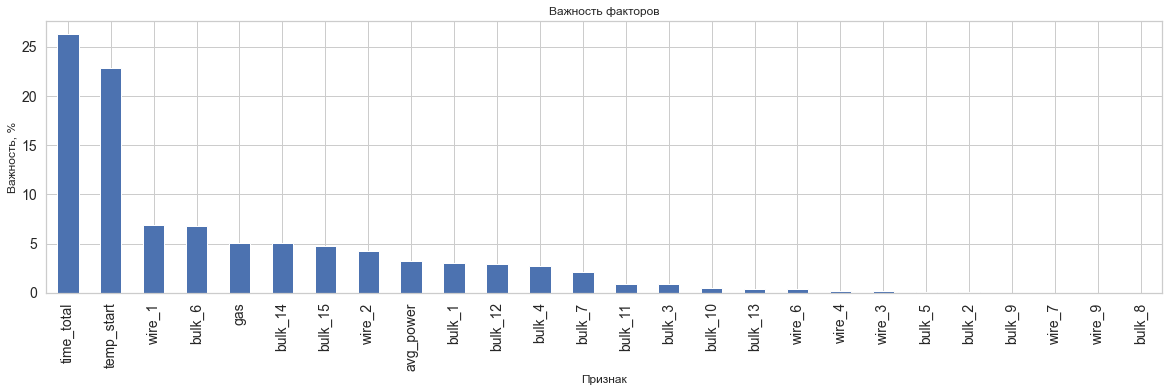

In [222]:
#Построим гарфик важности признаков
importance.plot(kind='bar', title='Важность факторов', x='Признак', y='Важность, %', ylabel='Важность, %', legend=False, figsize=(20,5), fontsize=14);

**Вывод**: Для модели CatBoostRegressor самые важные признаки:
- time_total - полное время нагрева за партию, сек.
- temp_start - температура во время начального замера


Доля этих признаков составляет 26% и 22% соответственно. На третьем месте признак wire_1 (объём проволочного материала с кодом 1), его доля ниже более чем в три раза и составляет чуть ниже 7%. Доля остальных признаков плавно уменьшается и достигает 0.

## Часть 3. Отчёт

### 1. Разбор плана работы

**1. Провести предобработку данных, если потребуется** - Выполнен

В ходе предобработки данных были выполнены следующие действия:
- удалены выбросы и аномальные значения в данных о нагреве электродами и в данных о температуре
- удалены партии, где отсутствовал замер финальной температуры
- Пропуски в данных о подаче сыпучих и проволочных материалах были заменены на 0
- из данных были удалены партии с отсутствующими значениями

Путём рассчётов были добавлены новые признаки:
- кол-во нагревов электродами за партию
- средняя полная мощность за нагрев
- полное время нагрева за партию
- температура во время начального замера (признак был извлечён из данных по температуре)

**2. Объединить таблицы для получения признаков для обучения модели** - Выполнен
<br><br>
**3. Проверка признаков на мультиколлениарность** - Выполнен

Были выявлены и удалены из данных коррелирующие признаки
<br><br>
**4. Разделить данные на выборки** - Выполнен
<br><br>
**5. Провести обучение модели** - Выполнен
<br><br>
**6. Проверить модель** - Выполнен
<br><br>
**7. Анализ важности факторов модели - победителя** - Выполнен

### 2. Трудности, которые возникли при выполнении работы
Главная трудность была понять суть процесса обработки стали и порядок этапов обработки. Были изучены данные о времени из таблиц по нагреву электродами и о подаче сыпучих и проволочных материалов, чтобы было понятно, какой процесс за каким следует и когда производится замер температуры.<br>
Ещё одна трудность возникла из-за того, что для построения модели в данных не хватало признаков и их пришлось создавать самому, для чего было необходимо изучить процесс обработки стали и порядок этапов, о чём уже писал выше.

### 3. Ключевые шаги
1. Изучить процесс обрабоки стали и порядок этапов в партии.
2. Уточнить, какие выбросы в данных являются аномалиями а какие значения выбросво допустимы и бывают в процессе обработки.
3. Правильно составить таблицу признаков для обучения модели. Понять, какие признаки стоит удалить, а какие новые - создать.

### 4. Итоговая модель
В результате сравнения нескольких моделей на тестовой выборке лучшее значение метрики MAE равное 6,33 показала модель **CatBoostRegressor**. На тестовой выборке дананя модель показала MAE равное 6,33.

### Список признаков, используемых для обучения лучшей модели и описание их предобработки

**Признаки, используемые для обучения модели:**
- **iterations** - кол-во нагревов электродами за партию
- **avg_power** - средняя полная мощность за нагрев
- **time_total** - полное время нагрева за партию, сек.
- **bulk_1 ... bulk_15** - объём сыпучего материала за партию
- **wire_1 ... wire_9** - объём прволочного материала за партию
- **gas** - данные по газ за партию
- **temp_start** - температура во время начального замера
- **temp_final** - температура во время финального замера. ***Целевой признак***

**Предобработка признаков:**
- Признак 'wire_5' был удалён, т.к. после удалений партий с отсутствующими значениями все значения данного признака в финальной таблице оказались раными 0, т.е. являлись заменёнными пропусками. 
- После результате проверки на мультиколлениарность были удалены признаки 'iterations' и 'wire_8'.

### Гиперпараметры лучшей модели
- 'max_depth'= 4
- 'n_estimators'= 140
- random_state = 190623

### Рекомендации по улучшению модели

Считаю, что к улучшению качества модели могут привести следующие действия:
- Добавление новых признаков. Их можно вычислить или из имеющихся данных, или получить из новых данных
- Удаление из признаков ещё нескольких мультиколлениарных признаков
- Подбор бОльшего числа гиперпараметров модели
- Удаление не значимых для модели признаков, выявленных в результате анализа важности признаков для модели